## Import data

In [2]:
import pandas as pd
pd.set_option("display.max_colwidth", None)
df = pd.read_csv("data/train.csv")

In [3]:
df.head()

id  \
0   0   
1   1   
2   2   
3   3   
4   4   

                                                                                           title  \
0              House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It   
1                                        FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart   
2                                                              Why the Truth Might Get You Fired   
3                                15 Civilians Killed In Single US Airstrike Have Been Identified   
4  Iranian woman jailed for fictional unpublished story about woman stoned to death for adultery   

               author  \
0       Darrell Lucus   
1     Daniel J. Flynn   
2  Consortiumnews.com   
3     Jessica Purkiss   
4      Howard Portnoy   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

OK, we've got five columns: `id`, `title`, `author`, `text`, `label`.

I see a lot of bullshit in the `text` column that we'll need to clean...

- newlines
- starting article by repeating title, author, date published
- twitter handles
- starting article with "Print" or "Videos", ending them with "Name"

Dr. Rubya mentioned that there will be missing values in the dataset. Where are they?

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


`info` above shows how many cells in each column are non-null.

There are 20,800 rows total.

- `id` has 0 missing values
- `title` has 558 missing values
- `author` has 1957 missing values
- `text` has 39 missing values
- `label` has 0 missing values

`text` is the most important field and the least-missing, so that's good. I think we can drop any rows that are missing `text`. 

## Article length

I'd like to see the distribution of article length.

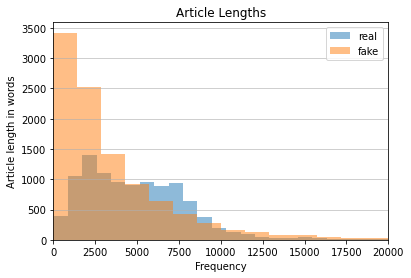

In [5]:
import matplotlib.pyplot as plt

df["length"] = df["text"].str.len()
lengths_real = df.loc[df["label"] == 0, "length"]
lengths_fake = df.loc[df["label"] == 1, "length"]


plt.hist(lengths_real, bins=100, alpha=0.5, label="real")
plt.hist(lengths_fake, bins=100, alpha=0.5, label="fake")
plt.xlim(0, 20_000)
plt.legend(loc="upper right")
plt.title("Article Lengths")
plt.xlabel("Frequency")
plt.ylabel("Article length in words")
plt.grid(axis="y", alpha=0.75)
plt.show()

So fake articles are more likely to be short, but it's not a great metric.

## Authors

Let's look at a sample of authors.

### Real authors:

In [6]:
df.loc[df["label"] == 0, "author"].sample(25)

11579                                 Neil MacFarquhar
15949             Michael D. Shear and Maggie Haberman
5356                                      Jess Bidgood
10902                                    Mike McIntire
19431    Brooks Barnes, Emily Steel and Michael Cieply
2664                                       Scott Shane
19146                              Nikole Hannah-Jones
14079                             Judith H. Dobrzynski
9711                                        Max Fisher
16585                                     Kate Zernike
17006                                Sabrina Tavernise
9330                                   Maggie Haberman
17127                                     Tom Ciccotta
12544                                 Michelle Higgins
15659                                   Scott Cacciola
4071                                     Jerome Hudson
18596                                     Sydney Ember
3946                                    Oliver JJ Lane
4760      

### Fake authors:

In [7]:
df.loc[df["label"] == 1, "author"].sample(25)

15724                         NaN
8559                  J. D. Heyes
19143                         IWB
15433                         NaN
13449    The Free Thought Project
6991               Kevin Gosztola
11846             King World News
8662                        admin
2206                    C.E. Dyer
14397                         NaN
656                           Dan
1649                    Mac Slavo
11803                     Glenn47
9212              Sausage Machine
10947                         NaN
10549              David Stockman
19258                    The Hill
18175                       admin
9697               Jameson Parker
10574              BareNakedIslam
5663                    Anonymous
1995                 Guest Author
7336                          NaN
2776                       Author
11508                           b
Name: author, dtype: object

Fake authors more likely to have missing author name. More 1 word names for fake authors. 

**Feature idea: `author_name_missing`**

**Feature idea: `author_name_one_word`**



## Article titles

Going to sample some real and fake article titles too look for potential features.

### Real article titles:

In [8]:
df.loc[df["label"] == 0, "title"].sample(25)

20760                                            ‘The Bodies Are Decomposing’ After Mudslide in Colombia - The New York Times
18709       Melania Trump: No Matter What the Opposition Is Saying, I Will Act in the Best Interest of All of You - Breitbart
11955                                         In Pearl Harbor Visit, a Symbol of Reconciliation in Japan - The New York Times
9110                                      Why So Many Business Leaders Are Tiptoeing Around Donald Trump - The New York Times
5904                                         Facebook to Begin ’Fake News’ Filtering in Germany Prior to Election - Breitbart
4283                                  Chapecoense Soccer Team’s Plane Crashes, Leaving Brazil Devastated - The New York Times
10624                                                               Donald Trump: Bring Back the ’Travel Ban’ to Fight Terror
807                                                            Oscar Voter: Meryl Streep Only Nominated for Anti-Trump

### Fake article titles:

In [9]:
df.loc[df["label"] == 1, "title"].sample(25)

7767                                                                                                                                                                                                      Truth in Media: Big Pharma, the FDA and Medical Propaganda
17233                                                                                                                                                                  Un exfutbolista brasileño pasará nueve años en prisión por transportar 800 kilos de marihuana
9560                                                                                                                                                                                               Orina encima de su ginecólogo para que le diga si está embarazada
13463                                                                                                                                                                                                      CNN Predicts 2

I see a lot of the real article titles include the publication name separated by a dash. I'm not sure if it's overfitting the specifics of this dataset, but:

**feature ideas: `publication_name`, `publication_name_missing`**

Will need to clean up publication name from the article title either way. 

- publication title is anything following a `(space)(- or |)(space)`

Some of these are in different languages. 

**feature idea: `language`**

Could use some sort of detection library to guess language? Not sure how that would impact prediction. Could filter out non-english articles if our feature engineering is english-specific. 

I also notice that the fake titles are more sensational. More highly positive or negative language.

**feature idea: `sentiment_title`**

I wonder if that would work for article text too. Maybe even paragraph by paragraph, or sentence by sentence? Could there be a difference in sentiment distribution throughout a real article vs. fake article? 

## Article text

I see that there are a lot of new line (`\n`) characters throughout the text column. Do most articles feature paragraph seperators?

In [28]:
df["n_paragraphs"] = df["text"].str.count("\\n")

df.head()

id  \
0   0   
1   1   
2   2   
3   3   
4   4   

                                                                                           title  \
0              House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It   
1                                        FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart   
2                                                              Why the Truth Might Get You Fired   
3                                15 Civilians Killed In Single US Airstrike Have Been Identified   
4  Iranian woman jailed for fictional unpublished story about woman stoned to death for adultery   

               author  \
0       Darrell Lucus   
1     Daniel J. Flynn   
2  Consortiumnews.com   
3     Jessica Purkiss   
4      Howard Portnoy   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [36]:

paras_real = df.loc[df["label"] == 0, "n_paragraphs"]
paras_fake = df.loc[df["label"] == 1, "n_paragraphs"]


print(f"Number of real articles: {len(paras_real)}")
print(f"Number of fake articles: {len(paras_fake)}")
print(f'Number of real articles with more than 0 paragraphs: {len(paras_real[paras_real > 0])}')
print(f'Number of fake articles with more than 0 paragraphs: {len(paras_fake[paras_fake > 0])}')

Number of real articles: 10387
Number of fake articles: 10413
Number of real articles with more than 0 paragraphs: 0
Number of fake articles with more than 0 paragraphs: 8160


None of the real articles use newline characters! It doesn't seem like a very generalizable feature, but maybe we should use it?